# Import Libraries

In [1]:
# Importing libraries needed for data cleaning and EDA
import pandas as pd
import numpy as np
import nltk
import re
import demoji
demoji.download_codes() # download the emoji library
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import ngrams
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer

/var/folders/90/274n3kt55bl4fjg8t134196r0000gn/T/ipykernel_1051/912544645.py:7: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes() # download the emoji library


In [2]:
# import scraped data which utilised praw API
df_anxiety_praw = pd.read_csv('../datasets/anxiety_praw.csv')
df_depression_praw = pd.read_csv('../datasets/depression_praw.csv')

In [3]:
# convert from unix timestamp to datetime format
df_depression_praw['created_utc'] = pd.to_datetime(df_depression_praw['created_utc'], unit='s')

In [4]:
# convert from unix timestamp to datetime format
df_anxiety_praw['created_utc'] = pd.to_datetime(df_anxiety_praw['created_utc'], unit='s')

In [5]:
# preview
df_anxiety_praw.head(2)

,id,created_utc,title,is_self,selftext,score,upvote_ratio,num_comments,permalink,author,distinguished
0,8zcjh1,2018-07-16 16:51:58,"Despite the anxiety, despite the depression, d...",False,NaN,7836,0.99,293,/r/Anxiety/comments/8zcjh1/despite_the_anxiety...,WoollyNinja,NaN
1,b18zmk,2019-03-15 01:55:17,Today I promised myself bacon and eggs if I co...,False,NaN,6048,0.99,242,/r/Anxiety/comments/b18zmk/today_i_promised_my...,Becky-and-Momo,NaN


In [6]:
# preview
df_depression_praw.head(2)

,id,created_utc,title,is_self,selftext,score,upvote_ratio,num_comments,permalink,author,distinguished
0,cd0hjp,2019-07-14 07:53:40,Shout out to the particular hell that is funct...,True,"This is me. Don’t get me wrong, it’s better th...",6678,1.0,348,/r/depression/comments/cd0hjp/shout_out_to_the...,fallen-fawn,NaN
1,i3ajk8,2020-08-04 01:57:38,I hate that people don’t understand that i don...,True,NaN,4723,1.0,260,/r/depression/comments/i3ajk8/i_hate_that_peop...,Nathanvic13,NaN


___

# Descriptive Statistics

In [7]:
df_anxiety_praw.describe()

,score,upvote_ratio,num_comments
count,996.000000,996.000000,996.000000
mean,1397.204819,0.990934,132.410643
std,669.388178,0.012402,672.385349
min,864.000000,0.880000,14.000000
25%,1010.000000,0.990000,63.000000
50%,1194.000000,0.990000,92.000000
75%,1504.000000,1.000000,125.000000
max,7836.000000,1.000000,18684.000000


In [8]:
df_depression_praw.describe()

,score,upvote_ratio,num_comments
count,969.000000,969.000000,969.000000
mean,1724.638803,0.992879,174.194014
std,658.385547,0.008459,474.880330
min,790.000000,0.910000,28.000000
25%,1227.000000,0.990000,96.000000
50%,1568.000000,0.990000,130.000000
75%,2060.000000,1.000000,172.000000
max,6678.000000,1.000000,8625.000000


## Information on two subreddits - r/depression and r/anxiety

An overview of total members, activity and engagement levels.

### r/depression

![r/depression subreddit information](../images/r_depression_subreddit_info.png)

### r/anxiety

![r/anxiety subreddit information](../images/r_anxiety_subreddit_info.png)

***Key findings:*** </br>
Based from the two subreddits, `r/depression` has approximately 942k members while `r/anxiety` has approximately 597k members. </br> </br>From the scrapped data and high level statistics, the engagement and activity level of members can be uncovered: </br>
___Engagement Level___
- Posts with high upvote ratio indicates that users are generally positive about the content and are more likely to engage with it by commenting or upvoting. Posts with low upvote ratio, may indicate that the content is controversial or unpopular, which can lead to less engagement.
- `r/depression` has a slightly higher mean upvote_ratio than `r/anxiety` (0.992887 vs 0.990944) which indicates that users in `r/depression` are slightly more engaged.

___Activity Level___
- Scores and number of comments are able to inform us on the activity level of a subreddit.
- Posts with a high score and large number of comments indicate that the subreddit is active and users are engaged in discussions. Posts with a low score and fewer comments may indicate a less active subreddit.
- `r/depression` has a higher mean score (1725 vs 1396) and higher mean number of comments (174 vs 132) than `r/anxiety`, which indicates that the users in `r/depression` are more active.

## Moderator Activity

In [9]:
# unique values for distinguished column
df_depression_praw['distinguished'].unique()

array([nan, 'moderator'], dtype=object)

In [10]:
# unique values for distinguished column
df_anxiety_praw['distinguished'].unique()

array([nan, 'moderator'], dtype=object)

In [11]:
# number of moderator posts within the top 1000
df_depression_praw['distinguished'].isin(['moderator']).sum()

6

In [12]:
# number of moderator posts within the top 1000
df_anxiety_praw['distinguished'].isin(['moderator']).sum()

2

***Key findings:*** </br>
- Top 1000 posts from both subreddits had extremely low moderators contribution (6 for `r/depression` and 2 for `r/anxiety`).
- This suggests that the top posts in subreddits are typically not made by moderators, and that the most popular content in a subreddit is often generated by regular users rather than moderators or admins.

In [13]:
# dataframe for moderator posts - r/depression
depression_moderator_posts_df = df_depression_praw[df_depression_praw['distinguished'] == 'moderator']

In [14]:
# view posts from moderators
for _, row in depression_moderator_posts_df.iterrows():
    print(f"Title: {row['title']}\n")
    print(f"Content: {row['selftext']}\n")
    print("------------------------------\n")

Title: Our most-broken and least-understood rules is "helpers may not invite private contact as a first resort", so we've made a new wiki to explain it

Content: We understand that most people who reply immediately to an OP with an invitation to talk privately  mean only to help, but this type of response usually leads to either disappointment or disaster.  it usually works out quite differently here than when you say "PM me anytime" in a casual social context.  

We have huge admiration and appreciation for the goodwill and good citizenship of so many of you who support others here and flag inappropriate content - even more so because we know that so many of you are struggling yourselves.  We're hard at work behind the scenes on more information and resources to make it easier to give and get quality help here - this is just a small start.  

Our new wiki page explains in detail why it's much better to respond in public comments, at least until you've gotten to know someone.  It will 

In [15]:
# dataframe for moderator posts - r/anxiety
anxiety_moderator_posts_df = df_anxiety_praw[df_anxiety_praw['distinguished'] == 'moderator']

In [16]:
# view posts from moderators
for _, row in anxiety_moderator_posts_df.iterrows():
    print(f"Title: {row['title']}\n")
    print(f"Content: {row['selftext']}\n")
    print("------------------------------\n")

Title: How to Breathe (a better way)

Content: Hey team! 

I hope your holidays went well, and if not, I’m glad to tell you that you survived them and are here to talk about it!

If you’re here looking for a particular thread, please check out the following: 

* [2020 Umbrella Thread](https://www.reddit.com/r/Anxiety/comments/h036q3/2020_umbrella_thread/)
* [Good News Coronavirus Thread 2](https://www.reddit.com/r/Anxiety/comments/ioy7uo/good_news_coronavirus_thread_2/)
* [Coronavirus Discussion](https://www.reddit.com/r/Anxiety/comments/izpdus/coronavirus_discussion_thread/) 

I’d also like to remind everyone that we have an active Discord server: https://discord.gg/9sSCSe9

I wanted to talk about breathing.  

A very common technique for coping with anxiety is to breathe deeply - you’ve probably heard this or seen it in an infographic.  This is indeed a helpful technique, but unfortunately I don’t think it is explained well and I have often seen users say that it can make their anxie

***Key findings:*** </br>
- `r/depression` moderators conduct regular check-ins on users which could have attributed to the higher engagement rates.

## Create post_length feature

In [17]:
# length of each post
df_depression_praw['post_length'] = df_depression_praw['selftext'].str.len()
df_anxiety_praw['post_length'] = df_anxiety_praw['selftext'].str.len()

___

# Data Cleaning

## Null Values

In [18]:
# number of null values for r/depression
df_depression_praw.isnull().sum()

id                 0
created_utc        0
title              0
is_self            0
selftext          38
score              0
upvote_ratio       0
num_comments       0
permalink          0
author           146
distinguished    963
post_length       38
dtype: int64

In [19]:
# number of null values for r/anxiety
df_anxiety_praw.isnull().sum()

id                 0
created_utc        0
title              0
is_self            0
selftext         225
score              0
upvote_ratio       0
num_comments       0
permalink          0
author           143
distinguished    994
post_length      225
dtype: int64

- It was earlier identified that the `distinguished` column had two values, nan and moderator. nan refers to the non-moderators also known as users. Thus, the NaN values for `distinguished` will be replaced with "user".

In [20]:
# replace NaN values for distinguished
df_depression_praw['distinguished'].fillna(value='user', inplace=True)

In [21]:
# replace NaN values for distinguished
df_anxiety_praw['distinguished'].fillna(value='user', inplace=True)

- `author` values could be null due to users deleting their accounts on reddit.
- `selftext` values could be null as users might just make a post with a title but no context within. We will confirm this below.

In [22]:
pd.set_option('display.max_colwidth', None)

In [23]:
# dataframe for empty selftext columns - r/depression
df_depression_nan = df_depression_praw[df_depression_praw['selftext'].isna()]

In [24]:
# dataframe for empty selftext columns - r/anxiety
df_anxiety_nan = df_anxiety_praw[df_anxiety_praw['selftext'].isna()]

In [25]:
df_depression_nan['title'].head(2)

1                                                                                                                                                     I hate that people don’t understand that i don’t want to kill myself, I just don’t want to be alive anymore
25    How do you tell someone... I'm not ignoring you right now. I'm just disconnected from reality right now, the days are all blurred together, and I feel completely numb towards everything around me. So it's really hard for me to maintain a conversation.
Name: title, dtype: object

In [26]:
df_anxiety_nan['title'].head(2)

0                                                             Despite the anxiety, despite the depression, despite all my self criticism and imperfections - I was a beautiful bride this Saturday!
1    Today I promised myself bacon and eggs if I could get myself to a coffee meet up. I was too anxious to attend last week. Guess who got bacon and eggs?!! Feeling so proud of myself for going.
Name: title, dtype: object

In [27]:
# Reset the maximum column width to its default value
pd.reset_option('display.max_colwidth')

- NaN values for `author` and `selftext` will be replaced with blanks.
- Columns should not be dropped as key data will be lost (e.g. those without selftexts have key information in the title)

In [28]:
df_depression_praw['author'].fillna(value=' ', inplace=True)

In [29]:
df_depression_praw['selftext'].fillna(value=' ', inplace=True)

In [30]:
df_depression_praw['post_length'].fillna(value=0, inplace=True)

In [31]:
df_anxiety_praw['author'].fillna(value=' ', inplace=True)

In [32]:
df_anxiety_praw['selftext'].fillna(value=' ', inplace=True)

In [33]:
df_anxiety_praw['post_length'].fillna(value=0, inplace=True)

In [34]:
df_depression_praw.isnull().sum()

id               0
created_utc      0
title            0
is_self          0
selftext         0
score            0
upvote_ratio     0
num_comments     0
permalink        0
author           0
distinguished    0
post_length      0
dtype: int64

In [35]:
df_anxiety_praw.isnull().sum()

id               0
created_utc      0
title            0
is_self          0
selftext         0
score            0
upvote_ratio     0
num_comments     0
permalink        0
author           0
distinguished    0
post_length      0
dtype: int64

## Duplicate Entries

In [36]:
# dataframe for r/depression duplicates
depression_duplicates = df_depression_praw[df_depression_praw.duplicated(subset=['title', 'selftext'])]

In [37]:
# dataframe for r/anxiety duplicates
anxiety_duplicates = df_anxiety_praw[df_anxiety_praw.duplicated(subset=['title', 'selftext'])]

In [38]:
depression_duplicates

,id,created_utc,title,is_self,selftext,score,upvote_ratio,num_comments,permalink,author,distinguished,post_length
884,exo6f1,2020-02-02 13:08:26,Regular Check-In Post,True,Welcome to /r/depression's check-in post - a p...,1068,1.0,5283,/r/depression/comments/exo6f1/regular_checkin_...,circinia,moderator,650.0


In [39]:
anxiety_duplicates

,id,created_utc,title,is_self,selftext,score,upvote_ratio,num_comments,permalink,author,distinguished,post_length
543,1pedm5,2013-10-28 17:32:01,Anxiety,False,,1161,0.98,28,/r/Anxiety/comments/1pedm5/anxiety/,MystikGohan,user,0.0


In [40]:
# drop duplicates for r/depression
df_depression_praw.drop_duplicates(subset=['title', 'selftext'], inplace=True)

In [41]:
# drop duplicates for r/anxiety
df_anxiety_praw.drop_duplicates(subset=['title', 'selftext'], inplace=True)

## Drop moderator posts

As I would like to focus on posts from users, moderator posts will be dropped.

In [42]:
df_depression_praw = df_depression_praw.drop(df_depression_praw[df_depression_praw['distinguished'] == 'moderator'].index)

In [43]:
df_anxiety_praw = df_anxiety_praw.drop(df_anxiety_praw[df_anxiety_praw['distinguished'] == 'moderator'].index)

## Lemantize and further text cleaning

Create two functions:
- clean_text
    - removes underscores
    - lowercase the text
    - remove numbers
    - remove apostrophes
    - remove punctuations
    - remove links
    - remove whitespaces
    - remove emojis
- lemmatize
    - consider the context and converts the word to its meaningful base form, which is called Lemma.

Lemmatization and cleaning of text are essential preprocessing steps in natural language processing (NLP) because they help to standardize and simplify the text data, which makes it easier to analyze and understand.

Cleaning of text helps to reduce the noise in the data and eliminates irrelevant information that can interfere with the analysis. Cleaning of text also helps to normalize the text by making all the words lowercase, which is important because many NLP algorithms are case-sensitive.

Lemmatization involves reducing words to their base or root form, which can be useful for NLP tasks because it allows for the identification of common word stems.

In [141]:
def clean_text(text):
    # replace underscores and replace with spaces
    text = text.replace('_', ' ')

    # lowercase the texts
    text = text.lower()
    
    # remove numbers using regex that match one or more digits
    text = re.sub(r'\d+', '', text)
    
    # remove hypens and split the hyphenated words into individual words
    text = re.sub(r"-", " ", text)
    
    # remove apostrophes and split into individual words
    text = re.sub(r"'", "", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'s", " is", text)
    text = re.sub(r"'m", " am", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'d", " would", text)
    
    # remove punctuations using regex that match one or more punctuation characters
    text = re.sub(r'[^\w\s]+', '', text)
    
    # remove links
    words = text.split(' ')
    words_to_sub = [w for w in words if 'http' in w]

    if words_to_sub:
        for w in words_to_sub:
            new_word = re.sub('http.*', '', w)
            text = re.sub(w, new_word, text)
    
    # remove emojis
    text = demoji.replace(text, '')
    
    # remove whitespaces using regex that match one or more whitespace characters
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [45]:
def lemmatize(text):
    # instantiate the lemmatizer object
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    
    # remove stopwords from tokens
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    
    # lemmatize the tokens in the list of filtered tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    # join back into a string to return lemmatized text
    lemmatized_text = " ".join(lemmatized_tokens)
    
    return lemmatized_text

The two functions are then tested on the existing texts. But first, let's combine both title and text to be cleaned together in a single column.

In [46]:
# combine title and selftext so that they can be cleaned and lemmatized together.
df_depression_praw['title_selftext_comb'] = df_depression_praw['title'] + ' ' + df_depression_praw['selftext']
df_anxiety_praw['title_selftext_comb'] = df_anxiety_praw['title'] + ' ' + df_anxiety_praw['selftext']

### Clean text

In [47]:
# before cleaning - r/depression
df_depression_praw['title_selftext_comb'].head()

0    Shout out to the particular hell that is funct...
1    I hate that people don’t understand that i don...
2    If 10 years ago someone told me that in 10 yea...
3    It’s like I died at 15, but my body just kept ...
4    High-functioning depression: I feel like I'm l...
Name: title_selftext_comb, dtype: object

In [48]:
# post cleaning - r/depression
df_depression_praw['title_selftext_comb_clean'] = df_depression_praw['title_selftext_comb'].apply(clean_text)
df_depression_praw['title_selftext_comb_clean'].head()

0    shout out to the particular hell that is funct...
1    i hate that people dont understand that i dont...
2    if years ago someone told me that in years i w...
3    its like i died at but my body just kept on li...
4    high functioning depression i feel like im liv...
Name: title_selftext_comb_clean, dtype: object

In [49]:
# before cleaning - r/anxiety
df_anxiety_praw['title_selftext_comb'].head()

0    Despite the anxiety, despite the depression, d...
1    Today I promised myself bacon and eggs if I co...
2    Professor here, if you have missed class, plea...
3                                         I am busy.  
4    Have my first real, adult, job interview today...
Name: title_selftext_comb, dtype: object

In [50]:
# post cleaning - r/anxiety
df_anxiety_praw['title_selftext_comb_clean'] = df_anxiety_praw['title_selftext_comb'].apply(clean_text)
df_anxiety_praw['title_selftext_comb_clean'].head()

0    despite the anxiety despite the depression des...
1    today i promised myself bacon and eggs if i co...
2    professor here if you have missed class please...
3                                            i am busy
4    have my first real adult job interview today n...
Name: title_selftext_comb_clean, dtype: object

### Lemmatize text

In [51]:
# before lemmatize - r/depression
df_depression_praw['title_selftext_comb_clean'].head()

0    shout out to the particular hell that is funct...
1    i hate that people dont understand that i dont...
2    if years ago someone told me that in years i w...
3    its like i died at but my body just kept on li...
4    high functioning depression i feel like im liv...
Name: title_selftext_comb_clean, dtype: object

In [52]:
# post lemmatize - r/depression
df_depression_praw['title_selftext_comb_clean_lem'] = df_depression_praw['title_selftext_comb_clean'].apply(lemmatize)
df_depression_praw['title_selftext_comb_clean_lem'].head()

0    shout particular hell functional depression do...
1    hate people dont understand dont want kill don...
2    year ago someone told year would routinely sit...
3    like died body kept living im trapped inside a...
4    high functioning depression feel like im livin...
Name: title_selftext_comb_clean_lem, dtype: object

In [53]:
# before lemmatize - r/depression
df_anxiety_praw['title_selftext_comb_clean'].head()

0    despite the anxiety despite the depression des...
1    today i promised myself bacon and eggs if i co...
2    professor here if you have missed class please...
3                                            i am busy
4    have my first real adult job interview today n...
Name: title_selftext_comb_clean, dtype: object

In [54]:
# post lemmatize - r/anxiety
df_anxiety_praw['title_selftext_comb_clean_lem'] = df_anxiety_praw['title_selftext_comb_clean'].apply(lemmatize)
df_anxiety_praw['title_selftext_comb_clean_lem'].head()

0    despite anxiety despite depression despite sel...
1    today promised bacon egg could get coffee meet...
2    professor missed class please come back arent ...
3                                                 busy
4    first real adult job interview today also mana...
Name: title_selftext_comb_clean_lem, dtype: object

### Original text vs. Clean text vs Clean and Lemmatize text

### r/depression output

In [55]:
print('Original text:','\n')
print(df_depression_praw['title_selftext_comb'][0], '\n')
print('Clean text:','\n')
print(df_depression_praw['title_selftext_comb_clean'][0], '\n')
print('Clean and Lemmatize text:','\n')
print(df_depression_praw['title_selftext_comb_clean_lem'][0], '\n')

Original text: 

Shout out to the particular hell that is functional depression. This is me. Don’t get me wrong, it’s better than don’t-leave-my-bed-for-a-week depression. I am grateful I can be an independent person. But there is something uniquely horrible about being able to go to work every day, occasionally clean up after yourself, pay your bills, generally put yourself together enough to look like a human being... but that’s it. Nothing else. No social life. No hobbies. Constantly battling your mind. And being absolutely fucking exhausted all the time. 

Clean text: 

shout out to the particular hell that is functional depression this is me dont get me wrong its better than dont leave my bed for a week depression i am grateful i can be an independent person but there is something uniquely horrible about being able to go to work every day occasionally clean up after yourself pay your bills generally put yourself together enough to look like a human being but thats it nothing else 

### r/anxiety output

In [56]:
print('Original text:','\n')
print(df_anxiety_praw['title_selftext_comb'][0], '\n')
print('Clean text:','\n')
print(df_anxiety_praw['title_selftext_comb_clean'][0], '\n')
print('Clean and Lemmatize text:','\n')
print(df_anxiety_praw['title_selftext_comb_clean_lem'][0], '\n')

Original text: 

Despite the anxiety, despite the depression, despite all my self criticism and imperfections - I was a beautiful bride this Saturday!   

Clean text: 

despite the anxiety despite the depression despite all my self criticism and imperfections i was a beautiful bride this saturday 

Clean and Lemmatize text: 

despite anxiety despite depression despite self criticism imperfection beautiful bride saturday 



### Create a new column for each dataframe for bigram analysis of selftext later

In [57]:
df_depression_praw['selftext_clean'] = df_depression_praw['selftext'].apply(clean_text)

In [58]:
df_anxiety_praw['selftext_clean'] = df_anxiety_praw['selftext'].apply(clean_text)

In [59]:
# final shape for df_depression_praw
df_depression_praw.shape

(963, 16)

In [60]:
# final shape for df_anxiety_praw
df_anxiety_praw.shape

(993, 16)

___

# Exploratory Data Analysis

## Data Dictionary

In [61]:
df_depression_praw.head(1)

,id,created_utc,title,is_self,selftext,score,upvote_ratio,num_comments,permalink,author,distinguished,post_length,title_selftext_comb,title_selftext_comb_clean,title_selftext_comb_clean_lem,selftext_clean
0,cd0hjp,2019-07-14 07:53:40,Shout out to the particular hell that is funct...,True,"This is me. Don’t get me wrong, it’s better th...",6678,1.0,348,/r/depression/comments/cd0hjp/shout_out_to_the...,fallen-fawn,user,483.0,Shout out to the particular hell that is funct...,shout out to the particular hell that is funct...,shout particular hell functional depression do...,this is me dont get me wrong its better than d...


|Feature|Type|Dataset|Description|
|---|---|---|---|
|id|string|anxiety_praw.csv & depression_praw.csv|Unique identifier of a particular post or comment within a subreddit|
|created_utc|datetime64[ns]|anxiety_praw.csv & depression_praw.csv|The time the post or comment was created|
|title|String|anxiety_praw.csv & depression_praw.csv|The title of the post.|
|is_self|Boolean|anxiety_praw.csv & depression_praw.csv|Indicates whether the post is a self-post or not.|
|self_text|String|anxiety_praw.csv & depression_praw.csv|The actual text content of a self-post.n|
|score|Integer|anxiety_praw.csv & depression_praw.csv|The upvotes minus the downvotes of the post.|
|upvote_ratio|Float|anxiety_praw.csv & depression_praw.csv|The ratio of upvotes to total votes.|
|num_comments|Integer|anxiety_praw.csv & depression_praw.csv|The total number of comments on the post.|
|permalink|String|anxiety_praw.csv & depression_praw.csv|The permanent link to the post.|
|author|String|anxiety_praw.csv & depression_praw.csv|The username of the person who submitted the post.|
|distinguished|String|anxiety_praw.csv & depression_praw.csv|Indicates whether the post or comment has been distinguished by a moderator or admin.|
|post_length|Integer|anxiety_praw.csv & depression_praw.csv|Length of post|
|title_selftext_comb|String|anxiety_praw.csv & depression_praw.csv|Title and selftext combined|
|title_selftext_comb_clean|String|anxiety_praw.csv & depression_praw.csv|Title and selftext combined cleaned|
|title_selftext_comb_clean_lem|String|anxiety_praw.csv & depression_praw.csv|Title and selftext combined cleaned and lemmatized|
|selftext_clean|String|anxiety_praw.csv & depression_praw.csv|Selftext cleaned|

## Average post length for subreddits

In [62]:
# mean post length
depression_mean = df_depression_praw['post_length'].mean()
anxiety_mean = df_anxiety_praw['post_length'].mean()

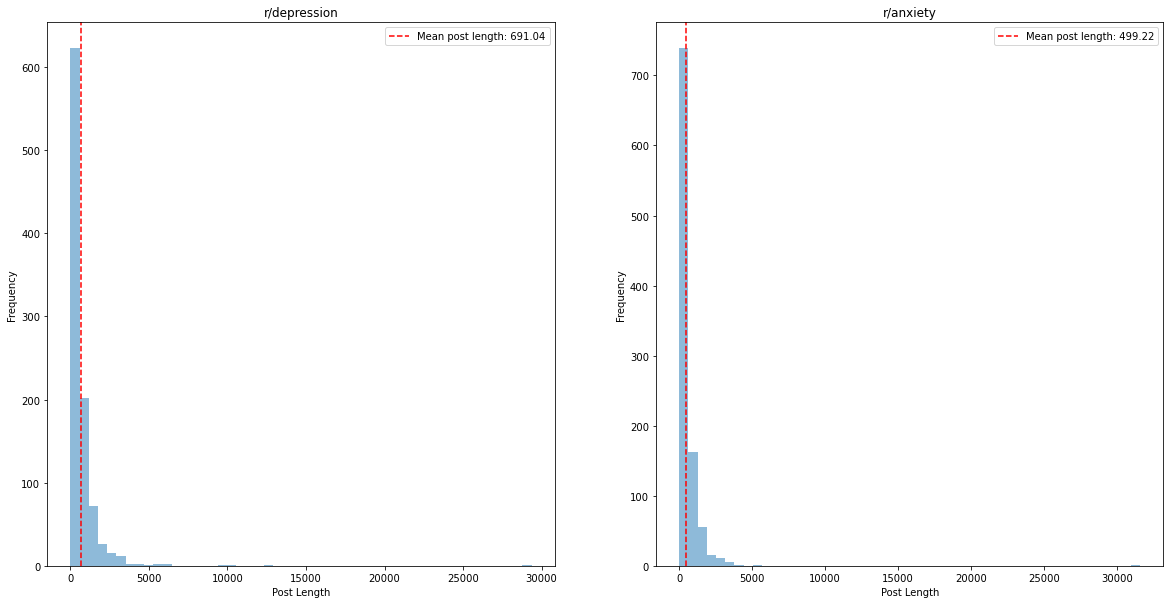

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.hist(df_depression_praw['post_length'], bins=50, alpha=0.5)
ax1.axvline(x=depression_mean, color='r', linestyle='--', label='Mean post length: {:.2f}'.format(depression_mean))
ax1.set_xlabel('Post Length')
ax1.set_ylabel('Frequency')
ax1.set_title('r/depression')
ax1.legend()

ax2.hist(df_anxiety_praw['post_length'], bins=50, alpha=0.5)
ax2.axvline(x=anxiety_mean, color='r', linestyle='--', label='Mean post length: {:.2f}'.format(anxiety_mean))
ax2.set_xlabel('Post Length')
ax2.set_ylabel('Frequency')
ax2.set_title('r/anxiety')
ax2.legend()

plt.show()

***Key Findings***:
- Posts on `r/depression` tend to be longer than posts on `r/anxiety`.

## Outliers

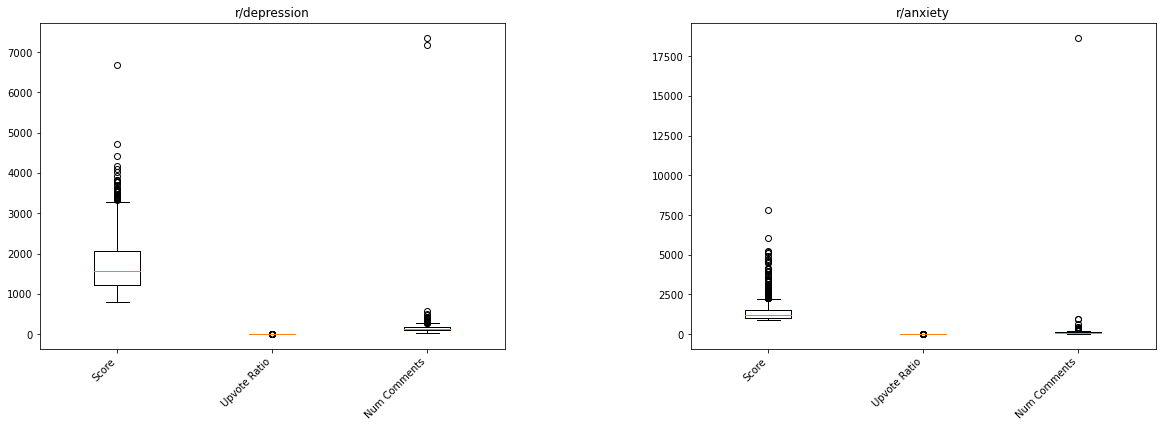

In [64]:
# figure for subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# boxplot for r/depression
depression_data = [df_depression_praw['score'], df_depression_praw['upvote_ratio'], df_depression_praw['num_comments']]
depression_labels = ['Score', 'Upvote Ratio', 'Num Comments']
ax1.boxplot(depression_data, labels=depression_labels)
ax1.set_title('r/depression')

# boxplot for r/anxiety
anxiety_data = [df_anxiety_praw['score'], df_anxiety_praw['upvote_ratio'], df_anxiety_praw['num_comments']]
anxiety_labels = ['Score', 'Upvote Ratio', 'Num Comments']
ax2.boxplot(anxiety_data, labels=anxiety_labels)
ax2.set_title('r/anxiety')

# spacing
fig.subplots_adjust(wspace=0.4)

# xtick label positon
for ax in [ax1, ax2]:
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# label size
for ax in [ax1, ax2]:
    ax.tick_params(axis='both', which='major', labelsize=10)

# figure size
fig.set_size_inches(20, 6)

# plot
plt.show()

## Num Comments Outliers

In [65]:
# zoom in on outlier for depression num comments
df_depression_num_comments_high = df_depression_praw[df_depression_praw['num_comments'] > 7000]

In [66]:
# display the posts
for _, row in df_depression_num_comments_high.iterrows():
    print(f"Title: {row['title']}\n")
    print(f"Content: {row['selftext']}\n")
    print("------------------------------\n")

Title: Regular Check-In Post

Content: Welcome to /r/depression's check-in post - a place to take a moment and share what is going on and how you are doing. If you have an accomplishment you want to talk about (these shouldn't be standalone posts in the sub as they violate the "role model" rule, but are welcome here), or are having a tough time but prefer not to make your own post, this is a place you can share.

We try our best to keep this space as safe and supportive as possible on reddit's wide-open anonymity-friendly platform. The community rules can be found in the sidebar, or under "Community Info" in the official mobile apps. If you aren't sure about a rule, [please ask us](https://www.reddit.com/message/compose?to=%2Fr%2Fdepression). 

*****

Sorry about letting the last post get archived.  We've been super-busy keeping up with the modqueue and that's slowing down our work on making the community rules more clear and visible and migrated to the standard reddit rules system - w

In [67]:
# zoom in on outlier for anxiety num comments
df_anxiety_num_comments_high = df_anxiety_praw[df_anxiety_praw['num_comments'] > 17500]

In [68]:
# display the posts
for _, row in df_anxiety_num_comments_high.iterrows():
    print(f"Title: {row['title']}\n")
    print(f"Content: {row['selftext']}\n")
    print("------------------------------\n")

Title: Let's post good news on the coronavirus here.

Content: A place where only good news is posted, please keep this a positive thread. a place we can go for some reassurance that everything will be okay. We WILL get through this.

edit: the link for this thread will be posted in the main thread, I will keep updating so save this thread to keep checking ♥️ stay healthy and wash those hands 😊 


guys for the love of god stay away from twitter, fb and all the big news outlets I know it's hard but no good will come out of it

this is a good article 

https://medium.com/@brandonricharda/10-reasons-to-feel-optimistic-de-spite-coronavirus-10073eae0ec4

JUST POSITIVE NEWS ABOUT COVID-19

There is so much negativity in the news about COVID-19, we want to give you all the positive news that is happening with research, clinical trials, improvements in statistics and anything that we can be positive about that you may not have seen.

Check this out guys

https://www.justgivemepositivenews.com/

## Score Outliers

In [69]:
# zoom in on post for outlier score for r/depression
df_depression_score_high = df_depression_praw[df_depression_praw['score'] > 4000]

In [70]:
# display posts
for _, row in df_depression_score_high.iterrows():
    print(f"Title: {row['title']}\n")
    print(f"Content: {row['selftext']}\n")
    print("------------------------------\n")

Title: Shout out to the particular hell that is functional depression.

Content: This is me. Don’t get me wrong, it’s better than don’t-leave-my-bed-for-a-week depression. I am grateful I can be an independent person. But there is something uniquely horrible about being able to go to work every day, occasionally clean up after yourself, pay your bills, generally put yourself together enough to look like a human being... but that’s it. Nothing else. No social life. No hobbies. Constantly battling your mind. And being absolutely fucking exhausted all the time.

------------------------------

Title: I hate that people don’t understand that i don’t want to kill myself, I just don’t want to be alive anymore

Content:  

------------------------------

Title: If 10 years ago someone told me that in 10 years I would be routinely sitting in my room all day doing nothing to make myself a successful man but eat, sleep and use my phone/pc and sometimes go out for a lonely aimless walks, I would 

In [71]:
# zoom in on post for outlier score for r/anxiety
df_anxiety_score_high = df_anxiety_praw[df_anxiety_praw['score'] > 7500]

In [72]:
# display posts
for _, row in df_anxiety_score_high.iterrows():
    print(f"Title: {row['title']}\n")
    print(f"Content: {row['selftext']}\n")
    print("------------------------------\n")

Title: Despite the anxiety, despite the depression, despite all my self criticism and imperfections - I was a beautiful bride this Saturday!

Content:  

------------------------------



***Key Findings***:
- Posts with highest scores are "negative" for r/depression and "positive" for r/anxiety.

## Distribution of Number of Comments

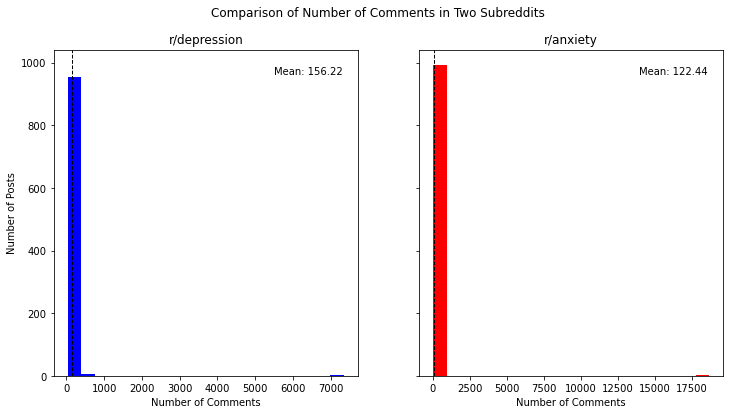

In [73]:
# extract number of comments
comments_depression = df_depression_praw['num_comments']
comments_anxiety = df_anxiety_praw['num_comments']

# calculate mean value
mean_comments_subreddit1 = comments_depression.mean()
mean_comments_subreddit2 = comments_anxiety.mean()

# subplot
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
fig.suptitle('Comparison of Number of Comments in Two Subreddits')

axs[0].hist(comments_depression, bins=20, color='blue')
axs[0].axvline(mean_comments_subreddit1, color='black', linestyle='dashed', linewidth=1)
axs[0].text(0.95, 0.95, f"Mean: {mean_comments_subreddit1:.2f}", ha='right', va='top', transform=axs[0].transAxes, color='black')
axs[0].set_title('r/depression')
axs[0].set_xlabel('Number of Comments')
axs[0].set_ylabel('Number of Posts')

axs[1].hist(comments_anxiety, bins=20, color='red')
axs[1].axvline(mean_comments_subreddit2, color='black', linestyle='dashed', linewidth=1)
axs[1].text(0.95, 0.95, f"Mean: {mean_comments_subreddit2:.2f}", ha='right', va='top', transform=axs[1].transAxes, color='black')
axs[1].set_title('r/anxiety')
axs[1].set_xlabel('Number of Comments')

plt.show()

***Key Findings***:
- On average, posts in r/depression tend to receive more comments than posts in r/anxiety.

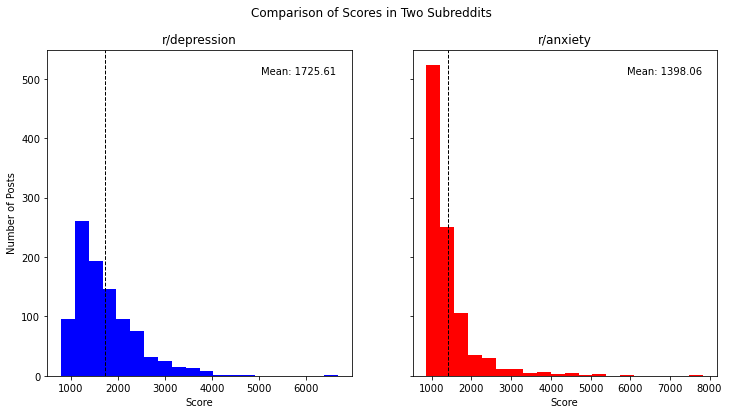

In [74]:
# extract score
score_depression = df_depression_praw['score']
score_anxiety = df_anxiety_praw['score']

# calculate mean value
mean_score_subreddit1 = score_depression.mean()
mean_score_subreddit2 = score_anxiety.mean()

# subplot
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
fig.suptitle('Comparison of Scores in Two Subreddits')

axs[0].hist(score_depression, bins=20, color='blue')
axs[0].axvline(mean_score_subreddit1, color='black', linestyle='dashed', linewidth=1)
axs[0].text(0.95, 0.95, f"Mean: {mean_score_subreddit1:.2f}", ha='right', va='top', transform=axs[0].transAxes, color='black')
axs[0].set_title('r/depression')
axs[0].set_xlabel('Score')
axs[0].set_ylabel('Number of Posts')

axs[1].hist(score_anxiety, bins=20, color='red')
axs[1].axvline(mean_score_subreddit2, color='black', linestyle='dashed', linewidth=1)
axs[1].text(0.95, 0.95, f"Mean: {mean_score_subreddit2:.2f}", ha='right', va='top', transform=axs[1].transAxes, color='black')
axs[1].set_title('r/anxiety')
axs[1].set_xlabel('Score')

plt.show()

***Key Findings***:
- On average, posts in r/depression tend to receive higher scores than posts in r/anxiety.

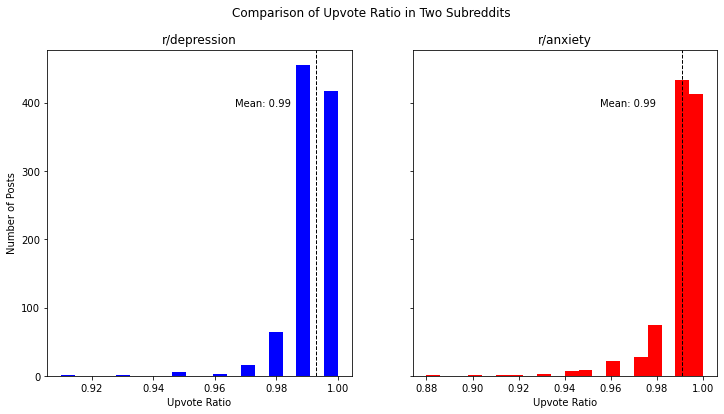

In [75]:
# extract upvote ratio
uvratio_depression = df_depression_praw['upvote_ratio']
uvratio_anxiety = df_anxiety_praw['upvote_ratio']

# calculate mean
mean_uvratio_subreddit1 = uvratio_depression.mean()
mean_uvratio_subreddit2 = uvratio_anxiety.mean()

# subplot
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
fig.suptitle('Comparison of Upvote Ratio in Two Subreddits')

# plot histogram for r/depression
axs[0].hist(uvratio_depression, bins=20, color='blue')
axs[0].axvline(mean_uvratio_subreddit1, color='black', linestyle='dashed', linewidth=1)
axs[0].text(0.8, 0.85, f"Mean: {mean_uvratio_subreddit1:.2f}", ha='right', va='top', transform=axs[0].transAxes, color='black')
axs[0].set_title('r/depression')
axs[0].set_xlabel('Upvote Ratio')
axs[0].set_ylabel('Number of Posts')

# plot histogram for r/anxiety
axs[1].hist(uvratio_anxiety, bins=20, color='red')
axs[1].axvline(mean_uvratio_subreddit2, color='black', linestyle='dashed', linewidth=1)
axs[1].text(0.8, 0.85, f"Mean: {mean_uvratio_subreddit2:.2f}", ha='right', va='top', transform=axs[1].transAxes, color='black')
axs[1].set_title('r/anxiety')
axs[1].set_xlabel('Upvote Ratio')

plt.show()

***Key Findings***:
- A mean upvote ratio of 0.99 indicates that almost all posts in both subreddits tend to be well-received by the community, as the vast majority of users are upvoting them. 

## N-gram Analysis

### Word Cloud

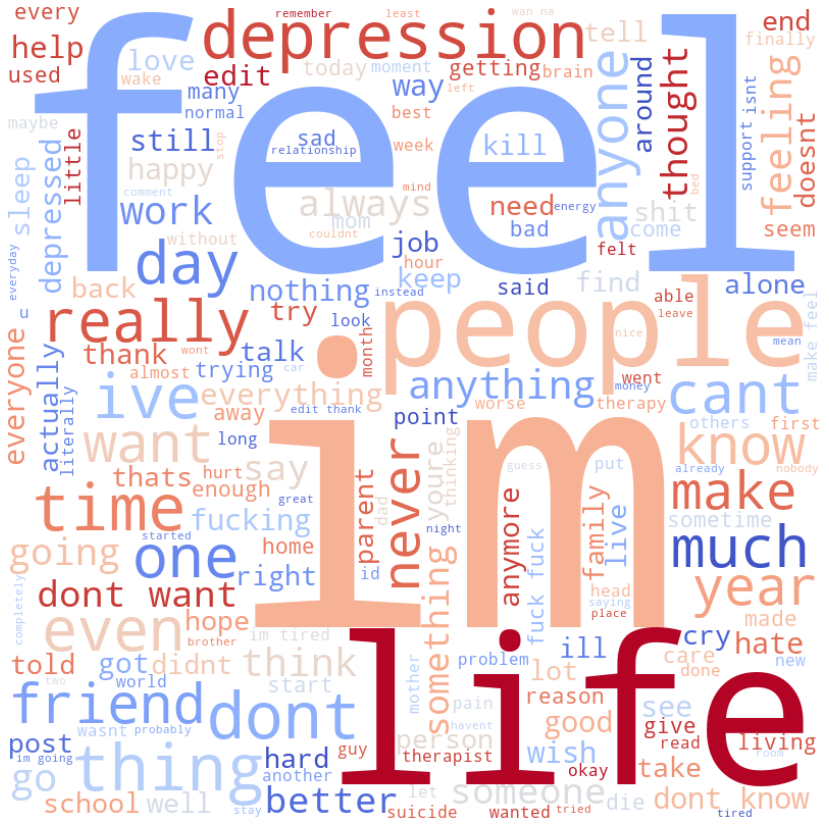

In [76]:
# combine the text data from the column of the dataframe
text = ' '.join(df_depression_praw['title_selftext_comb_clean_lem'])

# create a wordcloud object
wordcloud = WordCloud(width=800, height=800, background_color='white', colormap='coolwarm', stopwords=None, max_words=200).generate(text)

# plot the wordcloud
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

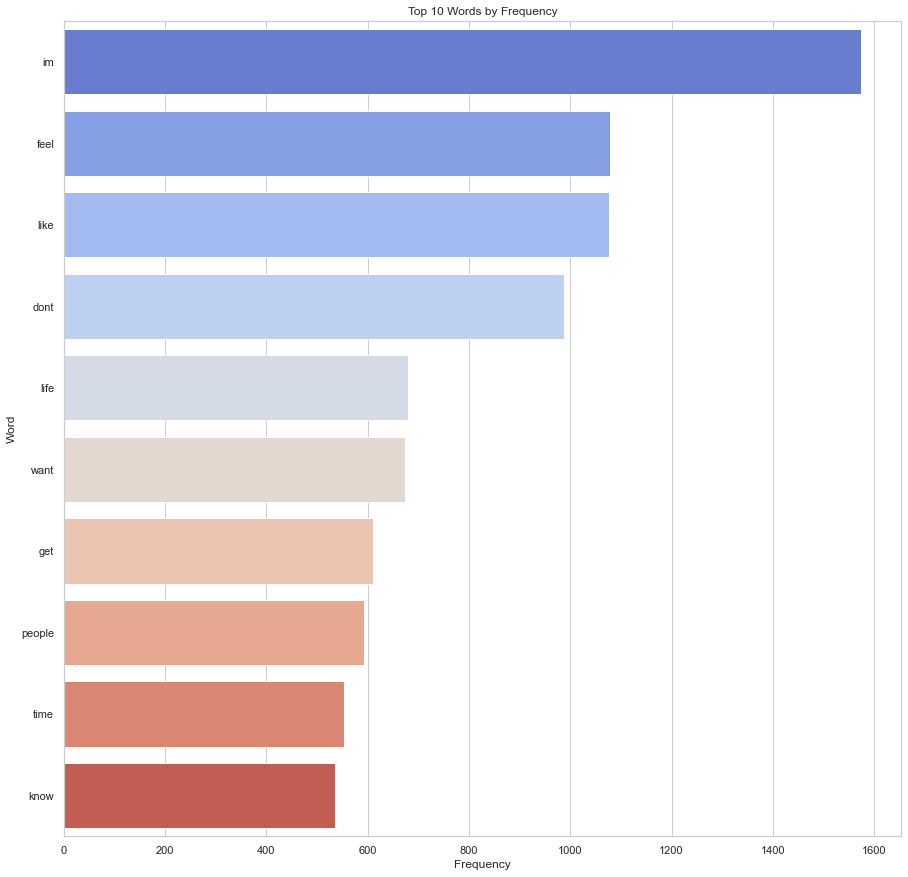

In [77]:
# get the text data from the dataframe
text = ' '.join(df_depression_praw['title_selftext_comb_clean_lem'])

# split the text into individual words
words = text.split()

# count the frequency of each word and create a dictionary
word_freq = dict(Counter(words))

# sort the dictionary by frequency in descending order and get the top 10 words
top_words = dict(sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:10])

# create a barplot of the top words
sns.set(style='whitegrid')
plt.figure(figsize=(15, 15))
plt.title('Top 10 Words by Frequency')
sns.barplot(x=list(top_words.values()), y=list(top_words.keys()), palette='coolwarm')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

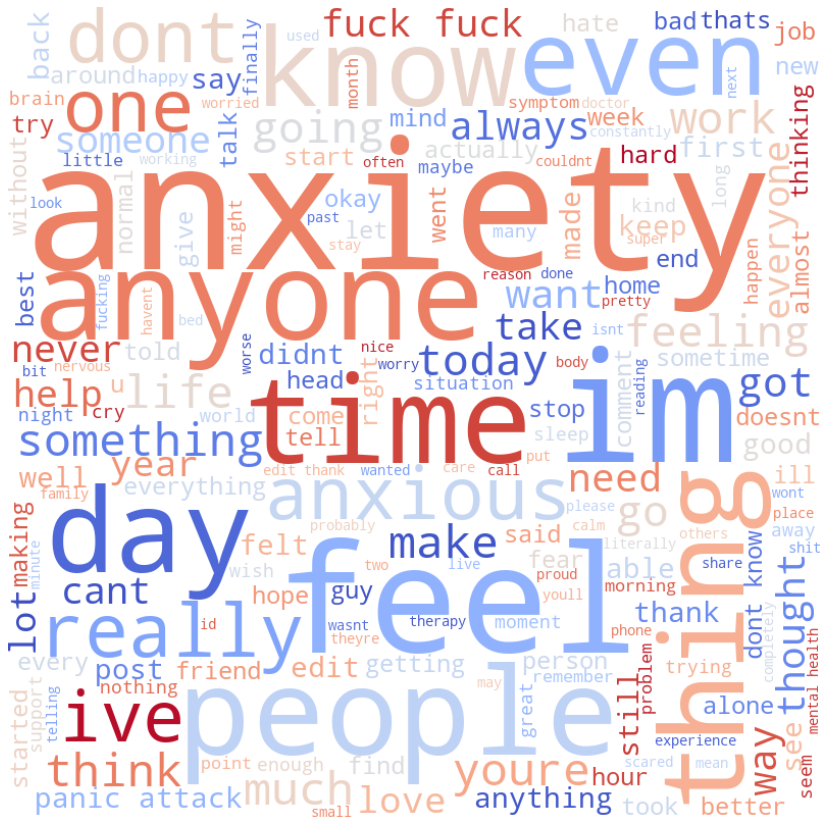

In [78]:
# combine the text data from the column of the dataframe
text = ' '.join(df_anxiety_praw['title_selftext_comb_clean_lem'])

# create a wordcloud object
wordcloud = WordCloud(width=800, height=800, background_color='white', colormap='coolwarm', stopwords=None, max_words=200).generate(text)

# plot the wordcloud
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

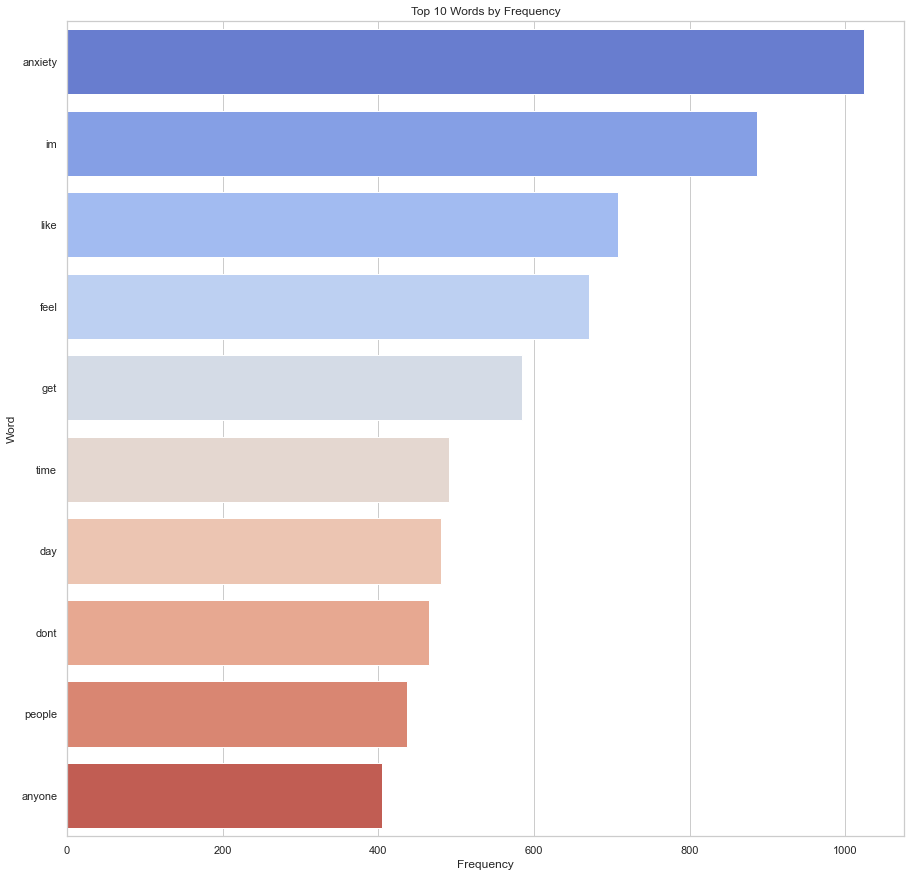

In [79]:
# get the text data from the dataframe
text = ' '.join(df_anxiety_praw['title_selftext_comb_clean_lem'])

# split the text into individual words
words = text.split()

# count the frequency of each word and create a dictionary
word_freq = dict(Counter(words))

# sort the dictionary by frequency in descending order and get the top 10 words
top_words = dict(sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:10])

# create a barplot of the top words
sns.set(style='whitegrid')
plt.figure(figsize=(15, 15))
plt.title('Top 10 Words by Frequency')
sns.barplot(x=list(top_words.values()), y=list(top_words.keys()), palette='coolwarm')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

***Key Findings***:
- Both subreddits use common words like "like", "im", "feel", "dont", "get", "people", and "time", but also have some distinct words that appear more frequently in one subreddit than the other, such as "life" and "want" for r/depression, and "anxiety" and "day" for r/anxiety.
- Both subreddits have some common themes, such as struggles with negative emotions, relationships and daily life challenges.
- Differences are the specifc concerns and experiences that the users are dealing with.
- e.g. r/depression focuses on issues related to finding the meaning and purpose in life while r/anxiety focuses on the experience of anxiety and how to manage it on a daily basis.

Examples from r/depression:

"Life feels meaningless and empty. I don't know what I want or where I'm going."
"I just want to feel better. I don't know what's wrong with me, but I can't shake this feeling of sadness and hopelessness."
"I don't like myself and I don't know how to change that. I feel like I'm stuck in this cycle of self-doubt and self-loathing."
- In these examples, we see the frequent use of words like "life", "want", "feel", and "like", which suggest that members of r/depression are struggling with issues related to finding meaning and purpose in life, understanding their emotions, and dealing with negative self-talk and self-esteem issues.

Examples from r/anxiety:

"I feel so anxious all the time. I can't stop worrying about everything, even little things that shouldn't matter."
"Does anyone else get panic attacks? I feel like I'm losing control and I don't know how to calm down."
"Anxiety is ruining my life. I can't focus on anything else, and I'm always on edge waiting for the next thing to trigger me."
- In these examples, we see the frequent use of words like "anxiety", "feel", "get", and "day", which suggest that members of r/anxiety are struggling with issues related to managing and coping with their anxiety on a daily basis, including panic attacks, worry, and difficulty focusing on other things.

# Bi-gram Analysis

## r/depression bi-gram analysis

In [80]:
# extract column of cleaned selftext
cleaned_text_column = df_depression_praw['selftext_clean']

In [81]:
# create list of bigrams
bigrams_list = [bigram for row in cleaned_text_column for bigram in ngrams(row.split(), 2)]

In [82]:
# create dictionary for frequency
bigram_freq = {}
for bigram in bigrams_list:
    if bigram in bigram_freq:
        bigram_freq[bigram] += 1
    else:
        bigram_freq[bigram] = 1

In [83]:
# convert bigram list to string
bigrams_text = ' '.join(['_'.join(bigram) for bigram in bigrams_list])

In [84]:
# generate wordcloud
wordcloud = WordCloud(width=800, height=800, background_color='white', colormap='coolwarm', stopwords=None, max_words=200).generate(bigrams_text)

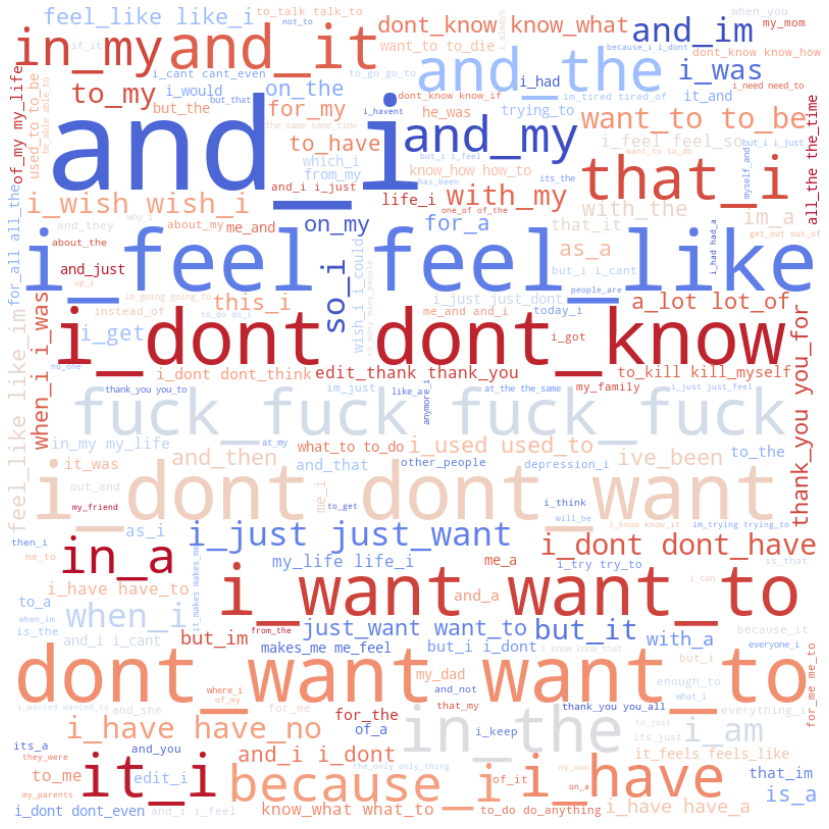

In [85]:
# wordcloud plot
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

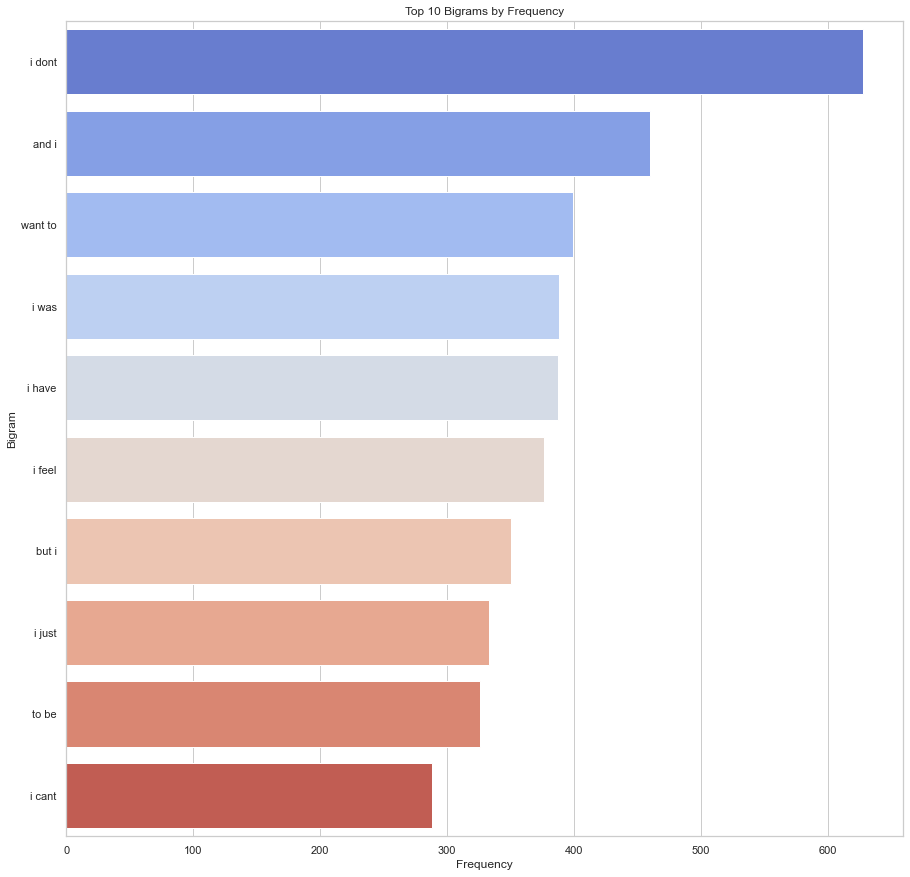

In [86]:
# sort dictionary in descending order with focus on top 10 bigrams
top_bigrams = dict(sorted(bigram_freq.items(), key=lambda x: x[1], reverse=True)[:10])

# barplot of top bigrams
sns.set(style='whitegrid')
plt.figure(figsize=(15, 15))
plt.title('Top 10 Bigrams by Frequency')
sns.barplot(x=list(top_bigrams.values()), y=[f"{bigram[0]} {bigram[1]}" for bigram in top_bigrams.keys()], palette='coolwarm')
plt.xlabel('Frequency')
plt.ylabel('Bigram')

plt.show()

## r/anxiety bi-gram analysis

In [87]:
# extract column of cleaned selftext
cleaned_text_column = df_anxiety_praw['selftext_clean']

In [88]:
# create list of bigrams
bigrams_list = [bigram for row in cleaned_text_column for bigram in ngrams(row.split(), 2)]

In [89]:
# create dictionary for frequency
bigram_freq = {}
for bigram in bigrams_list:
    if bigram in bigram_freq:
        bigram_freq[bigram] += 1
    else:
        bigram_freq[bigram] = 1

In [90]:
# convert bigram list to string
bigrams_text = ' '.join(['_'.join(bigram) for bigram in bigrams_list])

In [91]:
# generate wordcloud
wordcloud = WordCloud(width=800, height=800, background_color='white', colormap='coolwarm', stopwords=None, max_words=200).generate(bigrams_text)

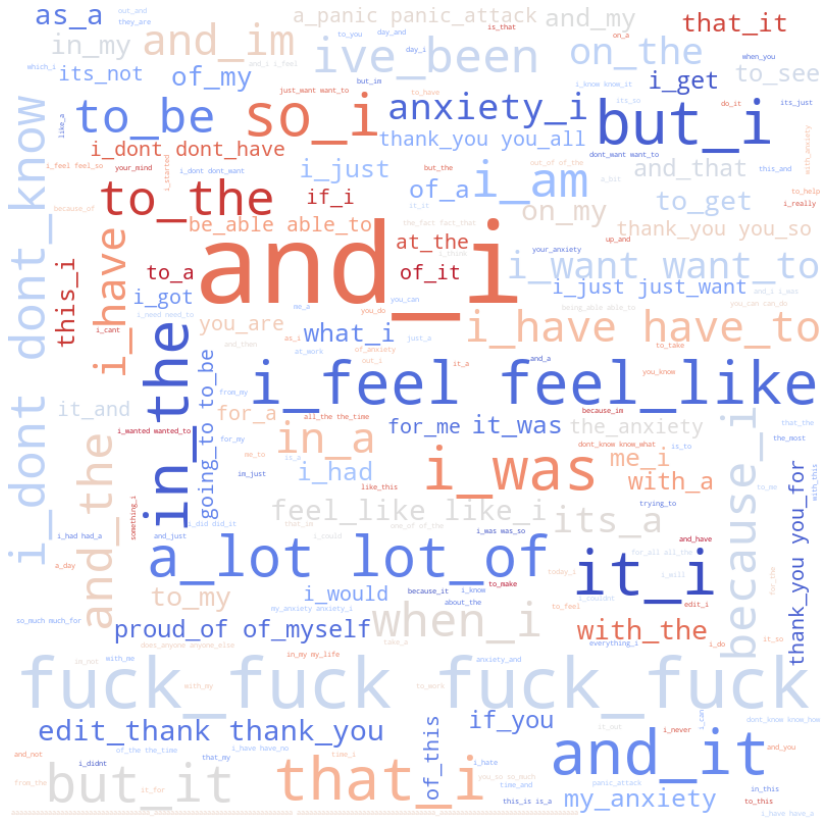

In [92]:
# wordcloud plot
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

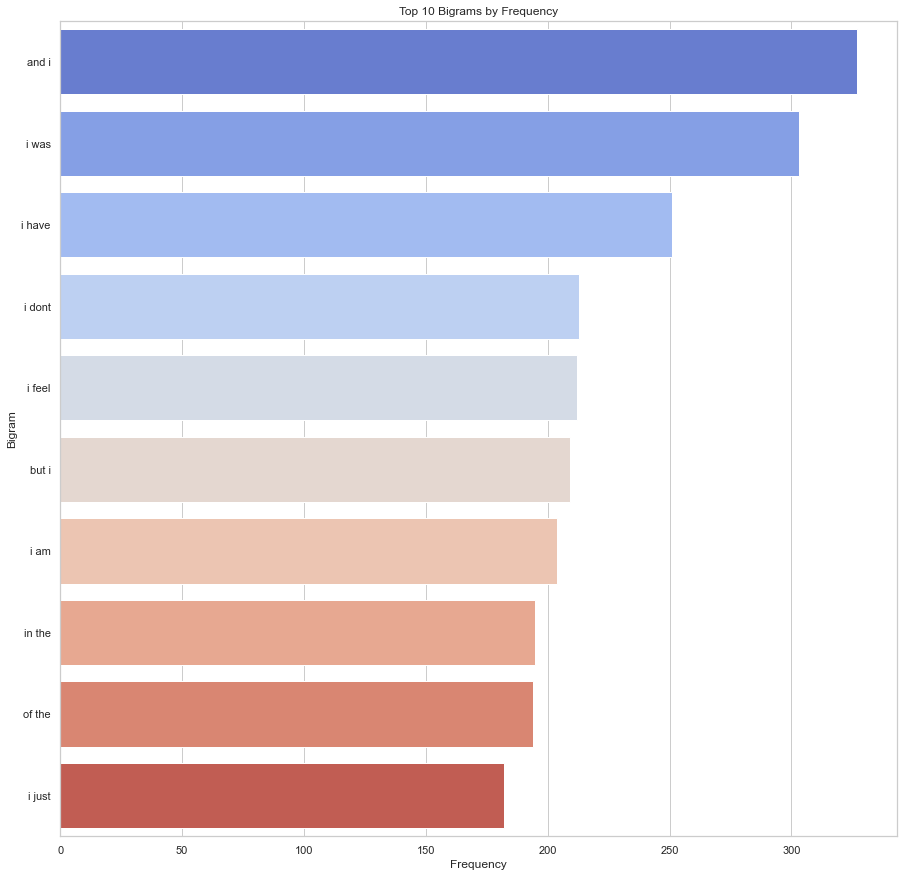

In [93]:
# sort dictionary in descending order with focus on top 10 bigrams
top_bigrams = dict(sorted(bigram_freq.items(), key=lambda x: x[1], reverse=True)[:10])

# barplot of top bigrams
sns.set(style='whitegrid')
plt.figure(figsize=(15, 15))
plt.title('Top 10 Bigrams by Frequency')
sns.barplot(x=list(top_bigrams.values()), y=[f"{bigram[0]} {bigram[1]}" for bigram in top_bigrams.keys()], palette='coolwarm')
plt.xlabel('Frequency')
plt.ylabel('Bigram')

plt.show()

***Key Findings***: </br>
- For r/depression, some of the most common bigrams include phrases such as "I don't," "I want to," "I have," "I was," "I feel," "I just," "to be," and "I can't." These phrases suggest a sense of hopelessness and helplessness, as well as a focus on negative emotions and experiences.

- On the other hand, the top bigrams for r/anxiety include phrases such as "and I," "I was," "I have," "I don't," "I feel," "but I," "I am," "in the," "of the," and "I just." These phrases suggest a focus on specific situations or events that trigger anxiety, as well as a sense of uncertainty and hesitation.

- Overall, the differences in the top bigrams for these two subreddits suggest some distinctions in the experiences and perspectives of users dealing with depression and anxiety. However, it's important to note that this analysis is based on language patterns and does not provide a comprehensive understanding of these conditions or the people who experience them.

## User Posting Pattern

In [94]:
# replace empty strings with NaN values and drop rows with NaN values in the 'author' column
df_depression_praw['author'] = df_depression_praw['author'].str.strip().replace('', np.nan)
df = df_depression_praw.dropna(subset=['author'])

In [95]:
# count number of posts for each author and sort results in descending order
top_posters = df['author'].value_counts().sort_values(ascending=False)

In [96]:
# top 10 posters
top_10_posters = top_posters.head(10)

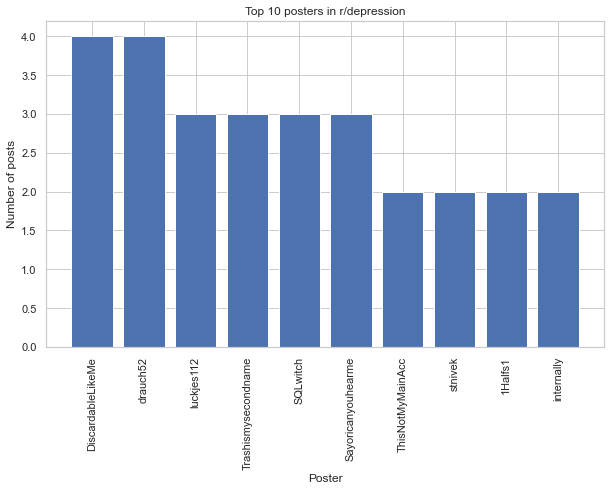

In [97]:
# barchart
plt.figure(figsize=(10, 6)) # Set the figure size to 10x6 inches
plt.bar(top_10_posters.index, top_10_posters.values)
plt.xlabel('Poster')
plt.ylabel('Number of posts')
plt.title('Top 10 posters in r/depression')

# Rotate the x-axis labels by 45 degrees
plt.xticks(rotation=90)

# plot
plt.show()

***Key Findings***:
- Top posters on r/depression contributed about 4 posts in the top 1000.
- It could suggest that the subreddit is more focused on discussion or community engagement rather than simply posting content, which may lead to fewer posts but more meaningful interactions.

In [98]:
pd.set_option('display.max_colwidth', None)

In [99]:
# Select the top poster
top_poster = top_posters.index[0]

# posts from top poster
top_poster_posts = df_depression_praw[df_depression_praw['author'] == top_poster]

In [100]:
# Print the titles and self_text of the top posts by the top poster
print(f"Top posts by {top_poster}: \n")
for index, row in top_poster_posts[['title', 'selftext']].iterrows():
    print(f"Title: {row['title']}")
    print(f"Self Text: {row['selftext']}")
    print()

Top posts by DiscardableLikeMe: 

Title: Anhedonia is the worst part of depression
Self Text: You're alive, but you aren't living. You feel like doing something, anything, but nothing is appealing. Everything feels like a chore, and it's exhausting. "Do things that you enjoy doing" doesn't work, since everything feels like watching paint dry. Realising that you're slowly beginning to lose interest in the few things you enjoy doing and realising that there's nothing you can do about it is mentally torturing. It's like trying to catch smoke with your bare hands; it's hopeless. The only thing you look forwards to is death.

Title: I'm addicted to everything that helps me forget that I'm me
Self Text: Be it books, video games, youtube, sleeping, whatever. As long as it's a temporary distraction I'm cool with it. They're not even especially fun anymore, but at this point almost anything's better than life's dull monotony.

Title: I'll tell my deepest, darkest secrets to strangers online, vo

In [101]:
# Reset the maximum column width to its default value
pd.reset_option('display.max_colwidth')

## Sentiment Analysis of Top 1000 posts for both r/depression and r/anxiety

In [102]:
# create a SentimentIntensityAnalyzer object
sid = SentimentIntensityAnalyzer()

In [103]:
# perform sentiment analysis for both subreddits using VADER
df_depression_praw['sentiment'] = df_depression_praw['title_selftext_comb_clean_lem'].apply(lambda x: sid.polarity_scores(x)['compound'])
df_anxiety_praw['sentiment'] = df_anxiety_praw['title_selftext_comb_clean_lem'].apply(lambda x: sid.polarity_scores(x)['compound'])

In [104]:
# get the mean sentiment scores for both subreddits
mean_sentiment_depression = np.mean(df_depression_praw['sentiment'])
mean_sentiment_anxiety = np.mean(df_anxiety_praw['sentiment'])

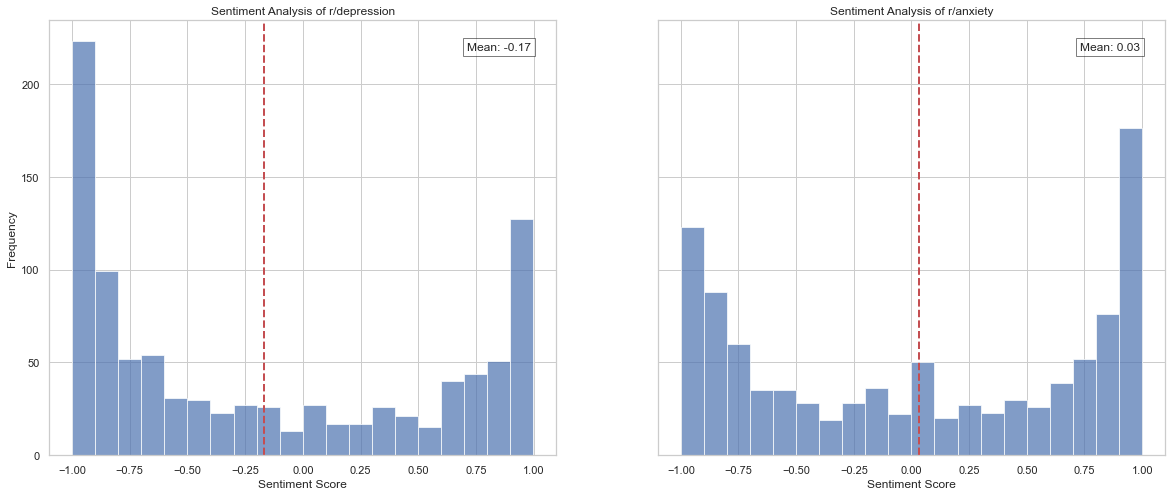

In [105]:
# create the side-by-side subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

n, bins, patches = axs[0].hist(df_depression_praw['sentiment'], bins=20, alpha=0.7)
axs[0].axvline(mean_sentiment_depression, color='r', linestyle='--', linewidth=2)
axs[0].text(0.95, 0.95, f"Mean: {mean_sentiment_depression:.2f}", transform=axs[0].transAxes,
             ha='right', va='top', bbox=dict(facecolor='white', edgecolor='black', alpha=0.5), fontsize=12)
axs[0].set_xlabel('Sentiment Score')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Sentiment Analysis of r/depression')

n, bins, patches = axs[1].hist(df_anxiety_praw['sentiment'], bins=20, alpha=0.7)
axs[1].axvline(mean_sentiment_anxiety, color='r', linestyle='--', linewidth=2)
axs[1].text(0.95, 0.95, f"Mean: {mean_sentiment_anxiety:.2f}", transform=axs[1].transAxes,
             ha='right', va='top', bbox=dict(facecolor='white', edgecolor='black', alpha=0.5), fontsize=12)
axs[1].set_xlabel('Sentiment Score')
axs[1].set_title('Sentiment Analysis of r/anxiety')

# Show the plot
plt.show()

***Key Findings***:
- The mean sentiment score for r/depression is actually -0.17, while the mean sentiment score for r/anxiety is 0.03.
- Majority of top posts on r/depression have a negative sentiment, with a mean sentiment score of around -0.17. This suggests that the posts on this subreddit tend to be more negative in tone, which is expected given the nature of the subreddit.
- r/anxiety shows that the sentiment scores are more evenly distributed around 0, with a mean sentiment score of around 0.03. This suggests that the posts on this subreddit have a more neutral sentiment overall, with both positive and negative posts being equally represented.

### Sample positive and negative posts from r/depression

In [106]:
highly_negative = df_depression_praw[df_depression_praw['sentiment'] < -0.9]

In [107]:
pd.set_option('display.max_colwidth', None)

In [108]:
highly_negative['selftext'].head(1)

0    This is me. Don’t get me wrong, it’s better than don’t-leave-my-bed-for-a-week depression. I am grateful I can be an independent person. But there is something uniquely horrible about being able to go to work every day, occasionally clean up after yourself, pay your bills, generally put yourself together enough to look like a human being... but that’s it. Nothing else. No social life. No hobbies. Constantly battling your mind. And being absolutely fucking exhausted all the time.
Name: selftext, dtype: object

In [109]:
highly_positive = df_depression_praw[df_depression_praw['sentiment'] > 0.9]

In [110]:
highly_positive['selftext'].head(1)

7    Does anyone else feel this way?  This has been crossing my mind a lot lately\n\nEDIT: I just want to thank everyone for the thoughtful, kind comments I've been recieving.  It's been a nice change and I really appreciate it.  You guys are the best.  :)
Name: selftext, dtype: object

### Sample positive and negative posts from r/anxiety

In [111]:
highly_negative = df_anxiety_praw[df_anxiety_praw['sentiment'] < -0.9]

In [112]:
highly_negative['selftext'].head(1)

8    Just one of the hellish cycles that anxiety gets me caught in. Can anyone else relate?
Name: selftext, dtype: object

In [113]:
highly_positive = df_anxiety_praw[df_anxiety_praw['sentiment'] > 0.9]

In [114]:
highly_positive['selftext'].head(1)

2    Hello, I’ve read a lot of posts recently about folks missing classes and feeling too anxious to come back. Don’t worry. We would much rather you come back to our classes than continue to miss. We teach because we care about you individually. We care about what’s going on in your lives. I know it’s easy to see professors as these omnipresent overlords but know that we are human and we have definitely been in your position before. Please feel better and know that you are always welcome back into class. Just shoot us an email and let us know what’s up so we can help you make up the work you missed.\n
Name: selftext, dtype: object

## Prepare for export

In [115]:
df_depression_praw['is_depression'] = 1

In [116]:
df_anxiety_praw['is_depression'] = 0

# Clean PSAW data to combine with PRAW

In [117]:
df_depression_psaw = pd.read_csv('../datasets/depression_ps.csv')
df_anxiety_psaw = pd.read_csv('../datasets/anxiety_ps.csv')

In [118]:
# convert from unix timestamp to datetime format
df_depression_psaw['created_utc'] = pd.to_datetime(df_depression_psaw['created_utc'], unit='s')

In [119]:
# convert from unix timestamp to datetime format
df_anxiety_psaw['created_utc'] = pd.to_datetime(df_anxiety_psaw['created_utc'], unit='s')

## Data cleaning

### Null values

In [120]:
df_depression_psaw.isnull().sum()

id                  0
created_utc         0
title               0
is_self             0
selftext            0
score               0
upvote_ratio        0
num_comments        0
permalink           0
author              0
distinguished    1000
dtype: int64

In [121]:
# replace NaN values for distinguished
df_depression_psaw['distinguished'].fillna(value='user', inplace=True)

In [122]:
df_anxiety_psaw.isnull().sum()

id                  0
created_utc         0
title               0
is_self             0
selftext           46
score               0
upvote_ratio        0
num_comments        0
permalink           0
author              0
distinguished    1000
dtype: int64

In [123]:
df_anxiety_psaw['selftext'].fillna(value=' ', inplace=True)

## Create post_length feature

In [124]:
# length of each post
df_depression_psaw['post_length'] = df_depression_praw['selftext'].str.len()
df_anxiety_psaw['post_length'] = df_anxiety_praw['selftext'].str.len()

In [125]:
df_depression_psaw['is_depression'] = 1

In [126]:
df_anxiety_psaw['is_depression'] = 0

## Clean and Lemmatize Texts

In [127]:
df_depression_psaw['title_selftext_comb'] = df_depression_psaw['title'] + ' ' + df_depression_psaw['selftext']
df_anxiety_psaw['title_selftext_comb'] = df_anxiety_psaw['title'] + ' ' + df_anxiety_psaw['selftext']

In [128]:
df_depression_psaw['title_selftext_comb_clean'] = df_depression_psaw['title_selftext_comb'].apply(clean_text)

In [129]:
df_anxiety_psaw['title_selftext_comb_clean'] = df_anxiety_psaw['title_selftext_comb'].apply(clean_text)

In [130]:
df_depression_psaw['title_selftext_comb_clean_lem'] = df_depression_psaw['title_selftext_comb'].apply(lemmatize)

In [131]:
df_anxiety_psaw['title_selftext_comb_clean_lem'] = df_anxiety_psaw['title_selftext_comb'].apply(lemmatize)

In [132]:
df_depression_psaw['selftext_clean'] = df_depression_psaw['selftext'].apply(clean_text)

In [133]:
df_anxiety_psaw['selftext_clean'] = df_depression_psaw['selftext'].apply(clean_text)

## Sentiment labels

In [134]:
# perform sentiment analysis for both subreddits using VADER
df_depression_psaw['sentiment'] = df_depression_psaw['title_selftext_comb_clean_lem'].apply(lambda x: sid.polarity_scores(x)['compound'])
df_anxiety_psaw['sentiment'] = df_anxiety_psaw['title_selftext_comb_clean_lem'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Combine all 4 dataframes to export for ML

In [135]:
# df_depression_praw
# df_anxiety_praw
# df_depression_psaw
# df_anxiety_psaw

In [136]:
# check columns
df_depression_praw.columns

Index(['id', 'created_utc', 'title', 'is_self', 'selftext', 'score',
       'upvote_ratio', 'num_comments', 'permalink', 'author', 'distinguished',
       'post_length', 'title_selftext_comb', 'title_selftext_comb_clean',
       'title_selftext_comb_clean_lem', 'selftext_clean', 'sentiment',
       'is_depression'],
      dtype='object')

In [137]:
df_anxiety_praw.columns

Index(['id', 'created_utc', 'title', 'is_self', 'selftext', 'score',
       'upvote_ratio', 'num_comments', 'permalink', 'author', 'distinguished',
       'post_length', 'title_selftext_comb', 'title_selftext_comb_clean',
       'title_selftext_comb_clean_lem', 'selftext_clean', 'sentiment',
       'is_depression'],
      dtype='object')

In [138]:
df_depression_psaw.columns

Index(['id', 'created_utc', 'title', 'is_self', 'selftext', 'score',
       'upvote_ratio', 'num_comments', 'permalink', 'author', 'distinguished',
       'post_length', 'is_depression', 'title_selftext_comb',
       'title_selftext_comb_clean', 'title_selftext_comb_clean_lem',
       'selftext_clean', 'sentiment'],
      dtype='object')

In [139]:
df_anxiety_psaw.columns

Index(['id', 'created_utc', 'title', 'is_self', 'selftext', 'score',
       'upvote_ratio', 'num_comments', 'permalink', 'author', 'distinguished',
       'post_length', 'is_depression', 'title_selftext_comb',
       'title_selftext_comb_clean', 'title_selftext_comb_clean_lem',
       'selftext_clean', 'sentiment'],
      dtype='object')

In [140]:
# concatenate the dataframes vertically
df_combined = pd.concat([df_depression_praw, df_anxiety_praw, df_depression_psaw, df_anxiety_psaw], ignore_index=True)

# remove duplicates
df_combined.drop_duplicates(inplace=True)

# export the dataframe to a CSV file
pd.DataFrame(df_combined).to_csv('../datasets/ML.csv', index = False)